In [1]:
# pip install basemap

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress
import datetime
import random
from scipy import stats
import seaborn as sns
#=========================================
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap

In [3]:
#Read .csv file for output
aviation_data = pd.read_csv("./dataset/airline_data.csv")
#aviation_data.head()

### Get columns from ./dataset/airline_data.csv we are going to perfom calculations on

In [4]:
aviation_data = pd.read_csv("./dataset/airline_data.csv")
aviation_data.head()
flights = aviation_data.to_dict(orient='records')
filtered_flights = []
for flight in flights:
    flight_date = str(flight["month"])
    if flight_date.startswith("11") or flight_date.startswith("12"):
        filtered_flights.append(flight)
print(len(filtered_flights))
formatted_flights = []
random_flights = random.sample(filtered_flights, min(200, len(filtered_flights)))
print(f"Number of randomly selected flights: {len(random_flights)}")
for flight in random_flights:
    airline_name = flight["carrier_name"]
    arrival_airport = flight["airport"]
    airport_name = flight["airport_name"]
    month = flight["month"]
    year = flight["year"]
    airline_delay = flight["carrier_delay"]
    weather_delay = flight["weather_delay"]
    nas_delay = flight["nas_delay"]
    security_delay = flight["security_delay"]
    late_aircraft_delay = flight["late_aircraft_delay"]
    count_airline_delay = flight["carrier_ct"]
    count_weather_delay = flight["weather_ct"]
    count_nas_delay = flight["nas_ct"]
    count_security_delay = flight["security_ct"]
    count_late_aircraft_delay = flight["late_aircraft_ct"]
    # NAS is the National Aviation System
    formatted_flights.append({
        "Year": year,
        "Month": month,
        "Airline Name": airline_name,
        "Arrival Airport": arrival_airport,
        "airport_name": airport_name,
        "Delay due to Airline in Mins": airline_delay,
        "Delay due to Weather in Mins": weather_delay,
        "Delay due to NAS in Mins": nas_delay,
        "Delay due to Security in Mins": security_delay,
        "Delay due to Late Aircraft in Mins": late_aircraft_delay,
        "# of Airline Delays": count_airline_delay,
        "# of Weather Delays": count_weather_delay,
        "# of NAS Delays": count_nas_delay,
        "# of Security Delays": count_security_delay,
        "# of Late Aircraft Delays": count_late_aircraft_delay
    })

11445
Number of randomly selected flights: 200


In [5]:
#Find unique values of the "flight_date"
print(aviation_data["flight_date"].unique())

['12/2023' '11/2023' '10/2023' '9/2023' '8/2023' '7/2023' '6/2023'
 '5/2023' '4/2023' '3/2023' '2/2023' '1/2023' '12/2022' '11/2022'
 '10/2022' '9/2022' '8/2022' '7/2022' '6/2022' '5/2022' '4/2022' '3/2022'
 '2/2022' '1/2022' '12/2021' '11/2021']


In [6]:
#Find random number of given flights
for flight in random_flights[:5]:
        print(flight["flight_date"])

11/2021
12/2021
12/2023
12/2023
12/2023


In [7]:
# Create and print Data Frame
flight_data_df = pd.DataFrame(formatted_flights)

#print(flight_data_df)

In [8]:
flight_data_df.to_csv("./dataset/flights.csv", index=True) #, mode='w')

flight_data_df = pd.read_csv("./dataset/flights.csv", index_col=0)

flight_data_df.head()

,Year,Month,Airline Name,Arrival Airport,airport_name,Delay due to Airline in Mins,Delay due to Weather in Mins,Delay due to NAS in Mins,Delay due to Security in Mins,Delay due to Late Aircraft in Mins,# of Airline Delays,# of Weather Delays,# of NAS Delays,# of Security Delays,# of Late Aircraft Delays
0,2021,11,GoJet Airlines LLC d/b/a United Express,LGA,"New York, NY: LaGuardia",66.0,0.0,87.0,0.0,239.0,1.12,0.00,3.00,0.0,2.88
1,2021,12,Delta Air Lines Network,CMH,"Columbus, OH: John Glenn Columbus International",381.0,55.0,56.0,0.0,74.0,7.95,0.95,2.20,0.0,2.90
2,2023,12,Envoy Air,MOB,"Mobile, AL: Mobile Regional",143.0,0.0,66.0,0.0,150.0,3.21,0.00,2.99,0.0,3.80
3,2023,12,Frontier Airlines,LIT,"Little Rock, AR: Bill and Hillary Clinton Nat ...",17.0,0.0,39.0,0.0,18.0,0.49,0.00,1.00,0.0,0.51
4,2023,12,Delta Air Lines Network,SMF,"Sacramento, CA: Sacramento International",1220.0,9.0,171.0,0.0,163.0,13.72,0.18,5.95,0.0,4.14


---

# U.S. Department of Transportation
## The information is presented from Federal Aviation Administration website

---

# Calculations based on Nov-Dec 2021-2023

## Import the data from .csv and the coordinates dataset and merge it with the existing dataset. 

In [9]:
#====Merging=====================================
'''"./dataset/airline_data.csv"'''
#flights_path_aa = "./dataset/flights_aa.csv"
flights_path = "./dataset/flights.csv"
airports_path = "./dataset/airports.csv"
#iata_coords_path = "iata_coords.csv"

flights_data = pd.read_csv(flights_path, low_memory=False)
airports_data = pd.read_csv(airports_path, low_memory=False)

#data_merged_df = pd.merge(airports_data, flights_data, on="Arrival Airport")

### Display the number of carriers with the lowest # of Late Airline Delays Nov-Dec   2021-2023

We group the rows in df by carrier and sum the number of delayed arrivals per carrier. We are only interested in the carriers
 with the smallest number of delayed arrivals. For display purposes,
 we pass the name parameter in our call to reset_index().
 data_ads_df   ---> # of smalest airline delays 

In [10]:
data_ads_df = flight_data_df 
data_ads_df.groupby('Airline Name')['# of Late Aircraft Delays'].count().nsmallest().reset_index(name='num_delays')

,Airline Name,num_delays
0,"Commutair Aka Champlain Enterprises, Inc.",1
1,GoJet Airlines LLC d/b/a United Express,1
2,Hawaiian Airlines Network,2
3,Horizon Air,4
4,JetBlue Airways,4


### Display the number of carriers with the largest # of Late Airline Delays  Nov-Dec   2021-2023

We group the rows in df by carrier and sum the number of delayed arrivals per carrier. We are only interested in the carriers
 with the largest number of delayed arrivals. For display purposes,
 we pass the name parameter in our call to reset_index().      data_adl_df   ---> # of largest airline delays 

In [11]:
data_adl_df = flight_data_df 
# nsmallest(10)   <----change the number
data_adl_df.groupby('Airline Name')['# of Late Aircraft Delays'].count().nlargest().reset_index(name='num_delays')

,Airline Name,num_delays
0,SkyWest Airlines Inc.,22
1,Delta Air Lines Network,16
2,Southwest Airlines,16
3,American Airlines Network,14
4,PSA Airlines Inc.,14


---

###   # of Late Aircraft Delays

In [12]:
# # Load the CSV file into a DataFrame
# df = pd.read_csv('./dataset/flights.csv')  # replace 'your_file.csv' with your actual file name

# # Display the first few rows of the DataFrame to understand its structure
# #print(df.head())

# # Assuming there is a column named 'time_minutes' that contains the time in minutes
# # Convert seconds to hours
# df['Delay due to Airline in Mins'] = (df['Delay due to Airline in Mins'] / 60).round(2)
# #Creat df for output
# out_df = pd.DataFrame(df)
# flights = out_df

In [13]:
# # Assuming you have a dataset named 'flights' with columns 'Airline Name' and 'Delay due to Weather in Mins'
# # Replace with your actual dataset and column names

# #Load your dataset
# #flights = out_df

# #Group by airline and calculate average delay
# airline_delays = flights.groupby('Airline Name')['Delay due to Airline in Mins'].mean().reset_index()

# # Sort by average delay
# airline_delays = airline_delays.sort_values(by='Delay due to Airline in Mins', ascending=False)

# # Create the bar plot
# plt.figure(figsize=(11, 6))
# plt.bar(airline_delays['Airline Name'], airline_delays['Delay due to Airline in Mins'])
# plt.xlabel('Airline Name')
# plt.ylabel('Average Delay (hours)')
# plt.title('Average Flight Delays due to Airline in Mins Nov-Dec 2021-2023')
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()
# #airline_delays

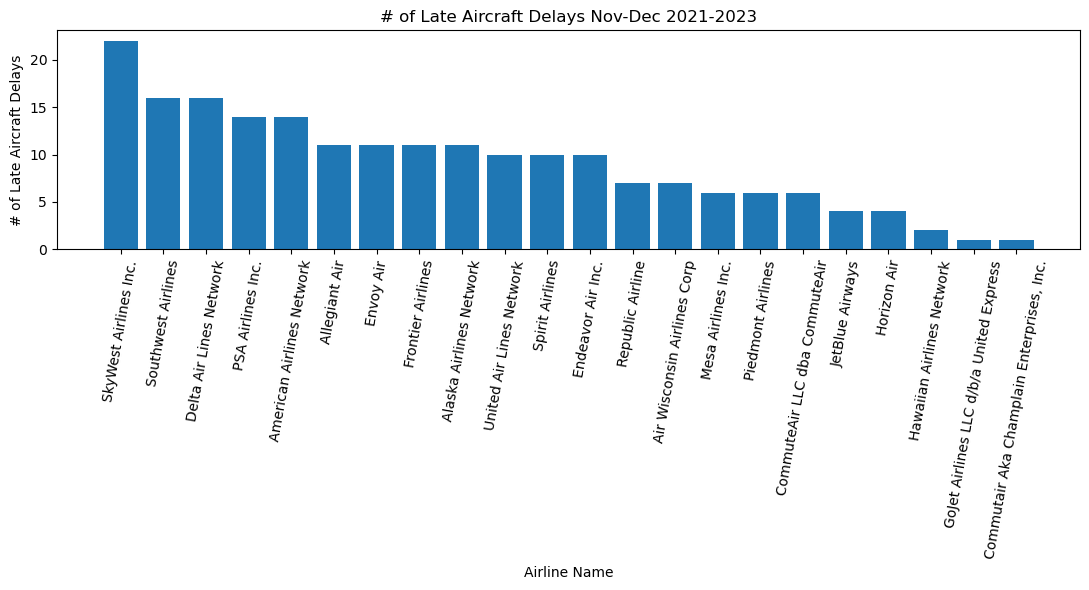

In [15]:
# Load your dataset
df = flight_data_df

# Group by airline and calculate average delay
airline_delays = df.groupby('Airline Name')['# of Late Aircraft Delays'].count().reset_index()

# Sort by average delay
airline_delays = airline_delays.sort_values(by='# of Late Aircraft Delays', ascending=False)

# Create the bar plot
plt.figure(figsize=(11, 6))
plt.bar(airline_delays['Airline Name'], airline_delays['# of Late Aircraft Delays'])
plt.xlabel('Airline Name')
plt.ylabel('# of Late Aircraft Delays')
plt.title('# of Late Aircraft Delays Nov-Dec 2021-2023')
plt.xticks(rotation= 80)
plt.tight_layout()
plt.show()
#airline_delays

### Basic statistical description of airlines
### *Calculate    min  max  count	 mean   on the # of Airline Delays  Nov-Dec  2021-2023*

### Grouping the number of airline delays by airline name, applying a statistical function to each group, and then reshaping the output for easier analysis.

In [16]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean().round()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = flight_data_df['# of Late Aircraft Delays'].groupby(flight_data_df['Airline Name']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count', ascending=False)
global_stats

,min,max,count,mean
Airline Name,,,,
SkyWest Airlines Inc.,0.00,21.02,22.0,6.0
Southwest Airlines,3.44,386.00,16.0,129.0
Delta Air Lines Network,0.00,171.02,16.0,16.0
PSA Airlines Inc.,0.00,12.98,14.0,5.0
American Airlines Network,8.14,351.77,14.0,64.0
Allegiant Air,0.00,10.09,11.0,3.0
Envoy Air,0.00,43.69,11.0,9.0
Frontier Airlines,0.00,39.00,11.0,9.0
Alaska Airlines Network,0.71,45.64,11.0,12.0


In [17]:
# # Read the CSV file into a DataFrame
# #df = pd.read_csv('flights.csv')  
# df = flight_data_df
# import matplotlib.pyplot as plt

# # Bar chart
# plt.figure(figsize=(12, 5))
# plt.bar(df['Airline Name'], df['# of Late Aircraft Delays'], color='skyblue')
# plt.xlabel('Airline Name')
# plt.ylabel('# of Late Aircraft Delays')
# plt.title('Bar Chart of Categories and Values')
# plt.xticks(rotation=80)
# plt.tight_layout()
# plt.show()

# # Scatter chart
# plt.figure(figsize=(8, 5))
# plt.scatter(df['# of Late Aircraft Delays'], df['# of Weather Delays'], color='blue', s=10)  # s is the size of points
# plt.xlabel('X Value')
# plt.ylabel('Y Value')
# plt.title('Scatter Chart of X and Y Values')
# plt.show()

In [18]:
# # Extract the unique list of airlines
# airlines = flight_data_df['Airline Name'].unique().tolist()

# # Display the list of airlines
# print("Available airlines:")
# for idx, airline in enumerate(airlines, start=1):
#     print(f"{idx}. {airline}")
# # Prompt the user to choose an airline
# while True:
#     try:
#         choice = int(input("Enter the number corresponding to the airline: "))
#         if 1 <= choice <= len(airlines):
#             selected_airline = airlines[choice - 1]
#             print(f"You selected: {selected_airline}")
#             break
#         else:
#             print("Please choose a valid number from the list.")
#     except ValueError:
#         print("Invalid input. Please enter a number.")

# df = flight_data_df[(flight_data_df['Airline Name'] == selected_airline)] #& (flight_data_df['# of Late Aircraft Delays'] > 0)]
# # Determine total number of NAS delay minutes by month.
# df_delays = df.groupby('Date')['# of Late Aircraft Delays'].count()



# # Plot NAS delay minutes by month for selected airline.
# plt.figure(figsize=(16, 8))

# plt.plot(df_delays)
# plt.xticks(rotation=85)
# plt.title("Average Flight Delay Over the Years")
# plt.xlabel("Year")
# plt.ylabel("Average Delay (minutes)")
# plt.grid(True)
# plt.show()

In [19]:
# december_2023_data = flight_data_df[
#     (flight_data_df['month'] == 12) & 
#     (flight_data_df['year'] == 2023)]